In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Dataset
from google.colab import files
uploaded=files.upload()

Saving Airlines+Data.xlsx to Airlines+Data.xlsx


In [5]:
# Read Dataset
airline = pd.read_excel('Airlines+Data.xlsx')
airline

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


**<h3>EDA</h3>**

In [8]:
airline.shape

(96, 2)

In [6]:
airline.isna().sum()

Month         0
Passengers    0
dtype: int64

In [7]:
airline.duplicated().sum()

0

In [9]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [10]:
airline.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [11]:
airline['month']=airline.Month.dt.strftime('%b')
airline['year']=airline.Month.dt.strftime('%Y')

airline['t']=np.arange(1,len(airline)+1)
airline['t_squared']=np.square(airline.t)
airline['log_passengers']=np.log(airline.Passengers)

In [12]:
airline.head()

,Month,Passengers,month,year,t,t_squared,log_passengers
0,1995-01-01,112,Jan,1995,1,1,4.718499
1,1995-02-01,118,Feb,1995,2,4,4.770685
2,1995-03-01,132,Mar,1995,3,9,4.882802
3,1995-04-01,129,Apr,1995,4,16,4.859812
4,1995-05-01,121,May,1995,5,25,4.795791


In [13]:
air=airline[['t','t_squared','month','Passengers','log_passengers']]
air.head()

,t,t_squared,month,Passengers,log_passengers
0,1,1,Jan,112,4.718499
1,2,4,Feb,118,4.770685
2,3,9,Mar,132,4.882802
3,4,16,Apr,129,4.859812
4,5,25,May,121,4.795791


In [14]:
air=pd.get_dummies(air)
air.head()

,t,t_squared,Passengers,log_passengers,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,1,1,112,4.718499,0,0,0,0,1,0,0,0,0,0,0,0
1,2,4,118,4.770685,0,0,0,1,0,0,0,0,0,0,0,0
2,3,9,132,4.882802,0,0,0,0,0,0,0,1,0,0,0,0
3,4,16,129,4.859812,1,0,0,0,0,0,0,0,0,0,0,0
4,5,25,121,4.795791,0,0,0,0,0,0,0,0,1,0,0,0


**<h3>Visualization</h3>**

<Axes: >

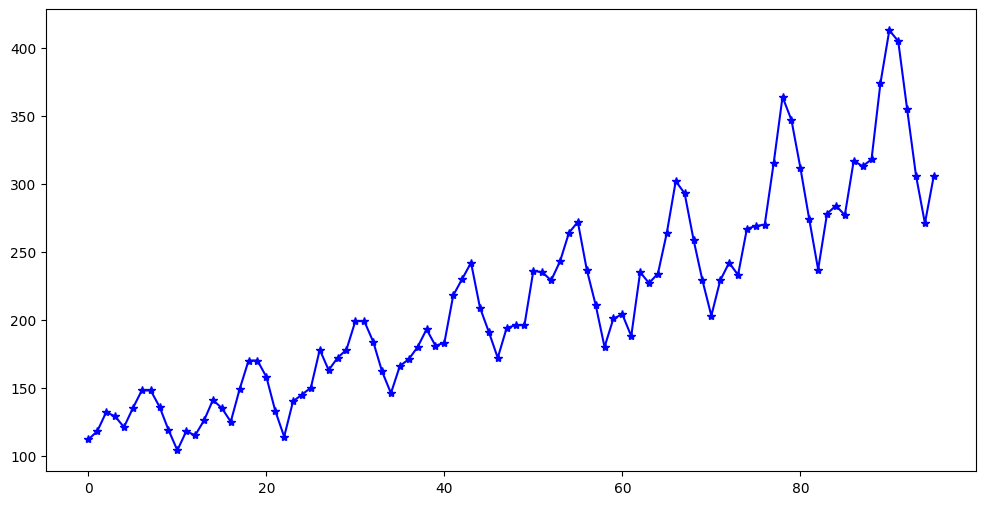

In [44]:
airline['Passengers'].plot(figsize=(12,6),color='blue',marker='*')

<Axes: xlabel='year', ylabel='Passengers'>

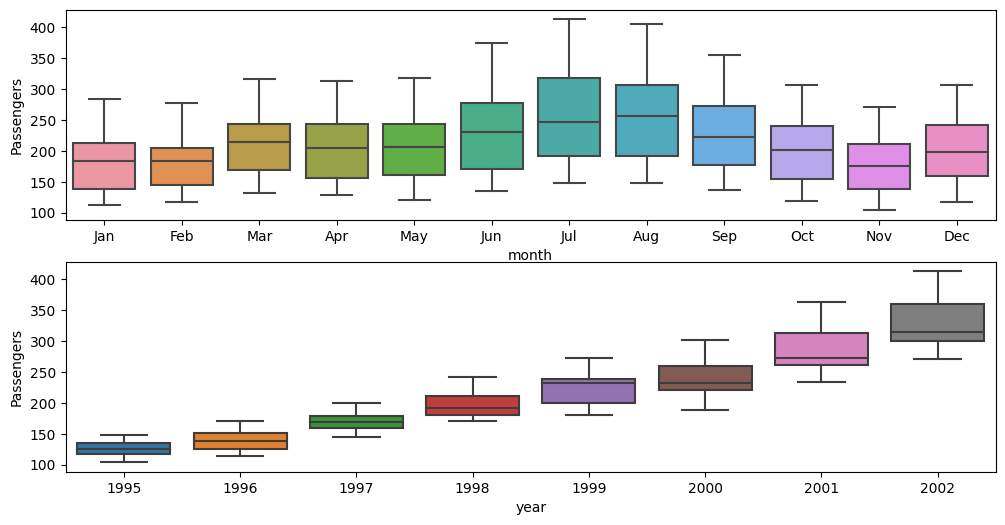

In [43]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
sns.boxplot(x='month',y='Passengers',data=airline)
plt.subplot(2,1,2)
sns.boxplot(x='year',y='Passengers',data=airline)

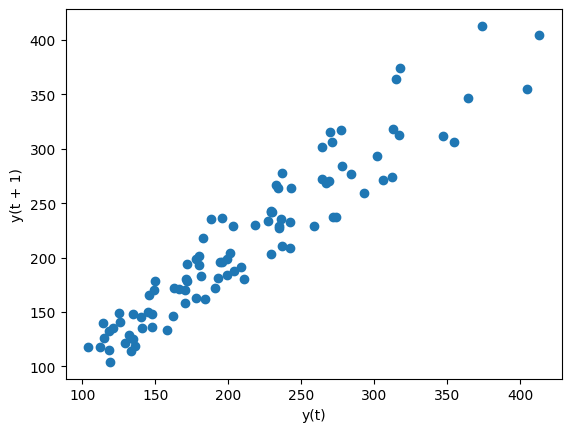

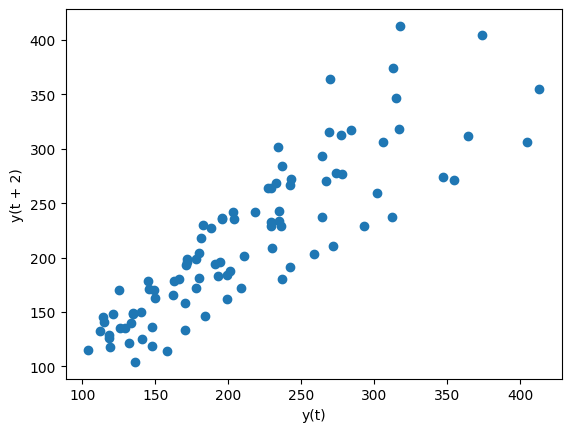

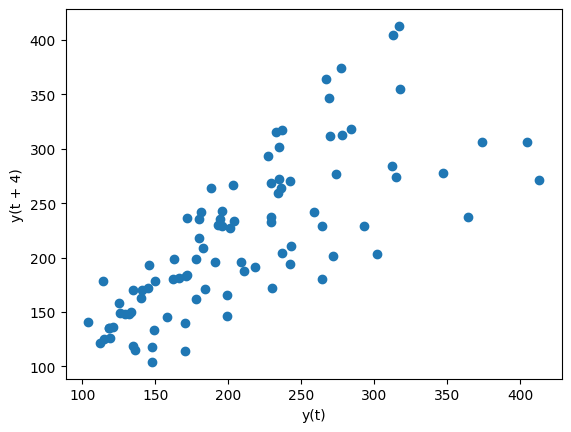

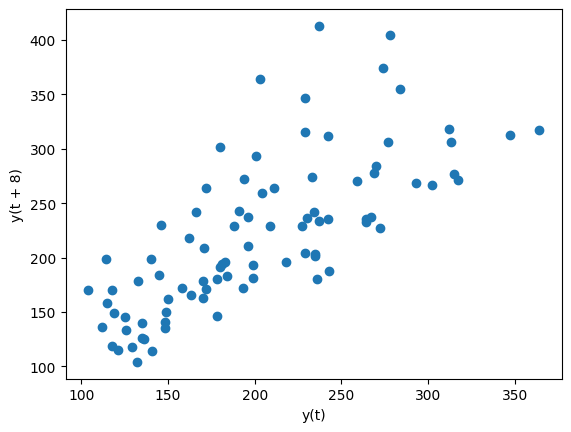

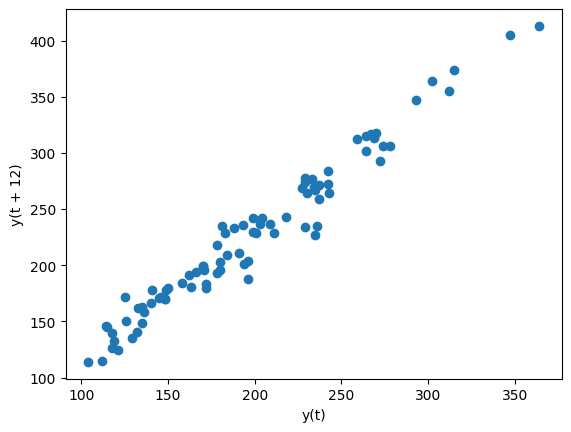

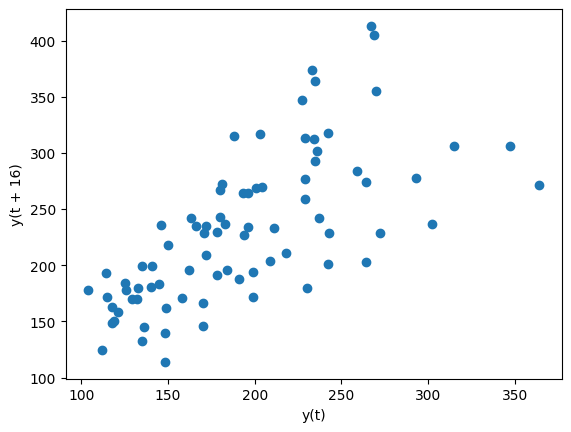

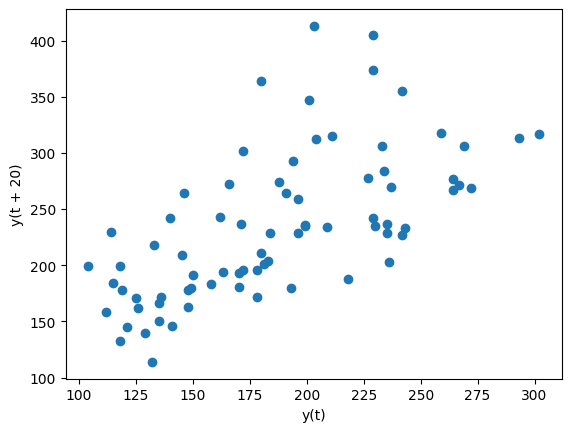

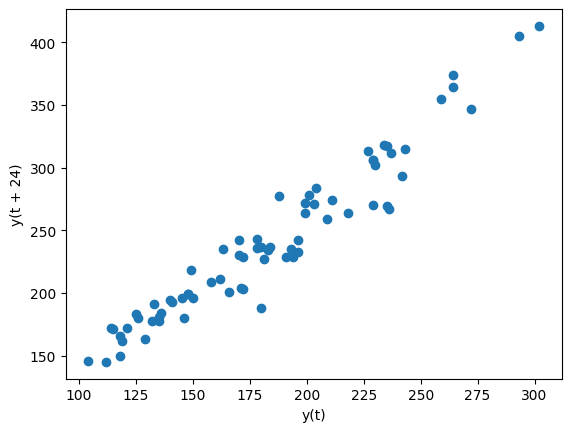

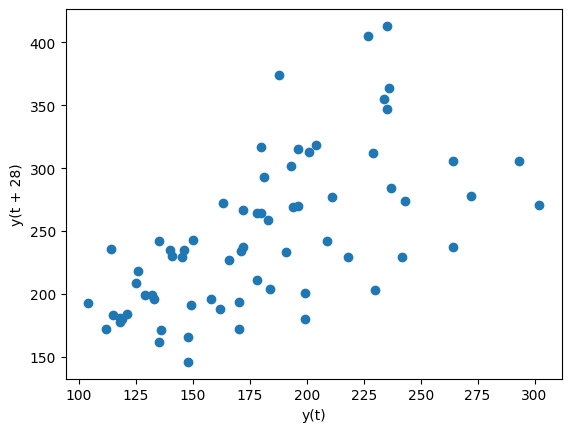

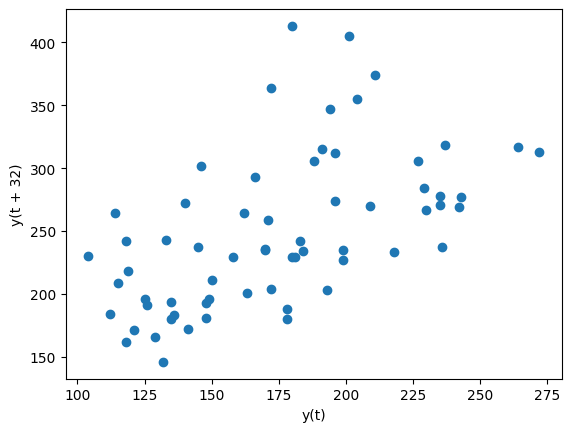

In [17]:
from pandas.plotting import lag_plot

for i in [1,2,4,8,12,16,20,24,28,32]:
  lag_plot(airline.Passengers,lag=i)
  plt.show()

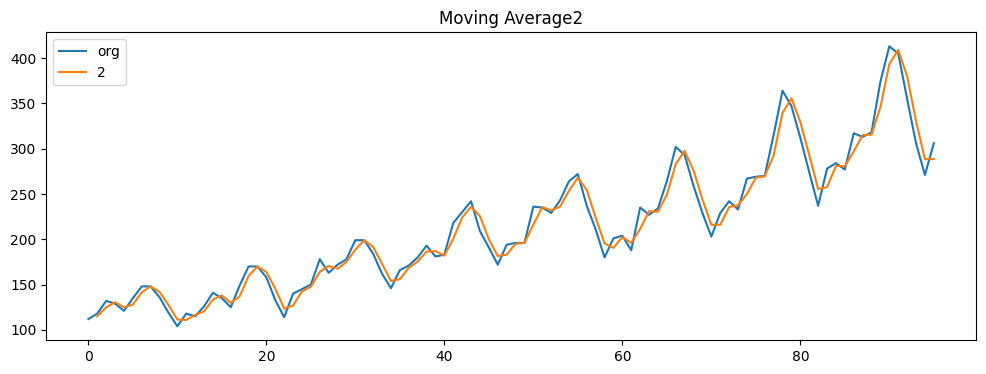

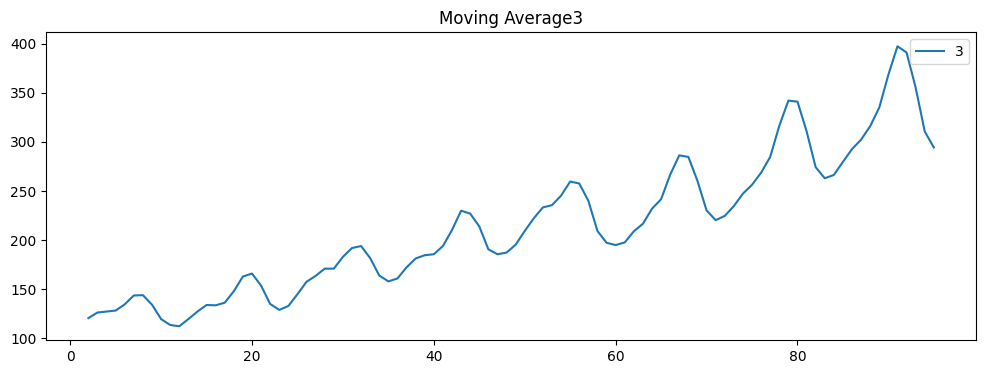

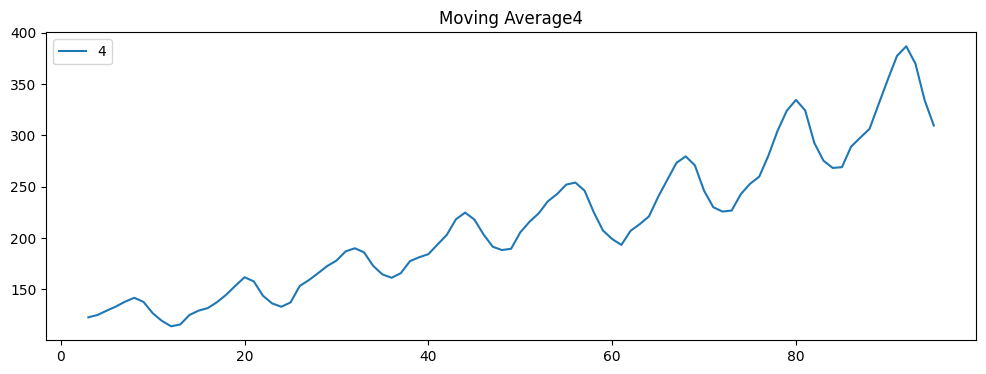

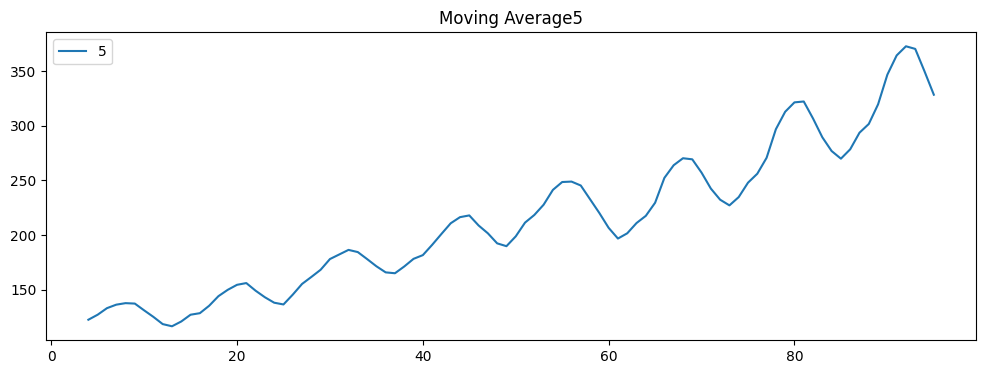

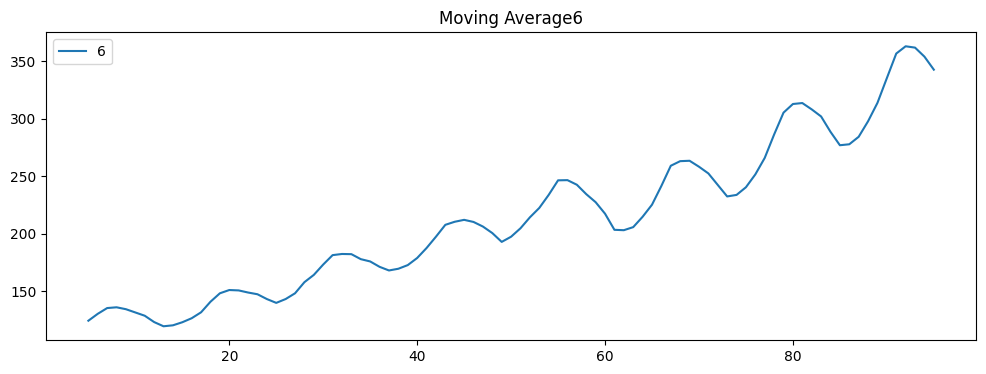

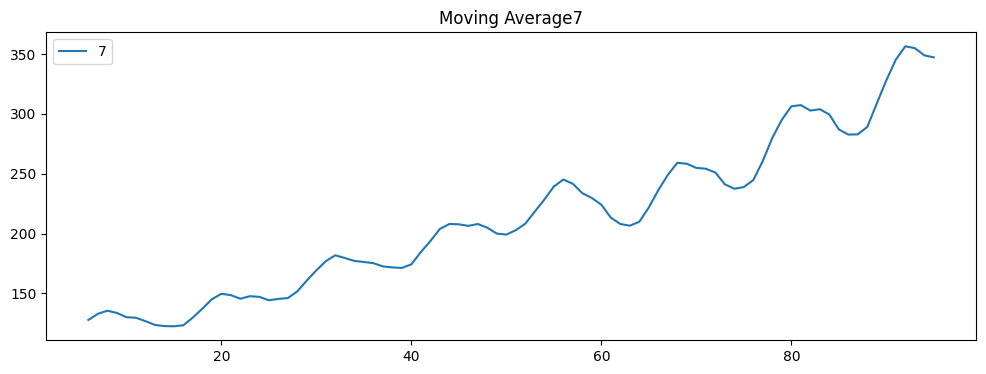

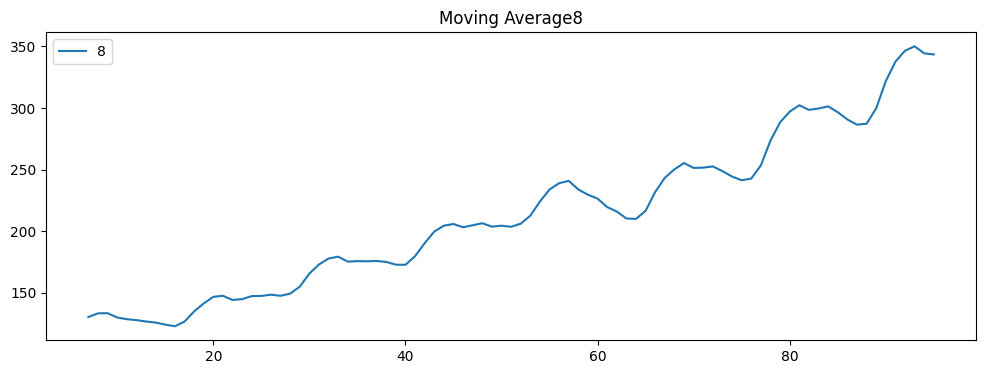

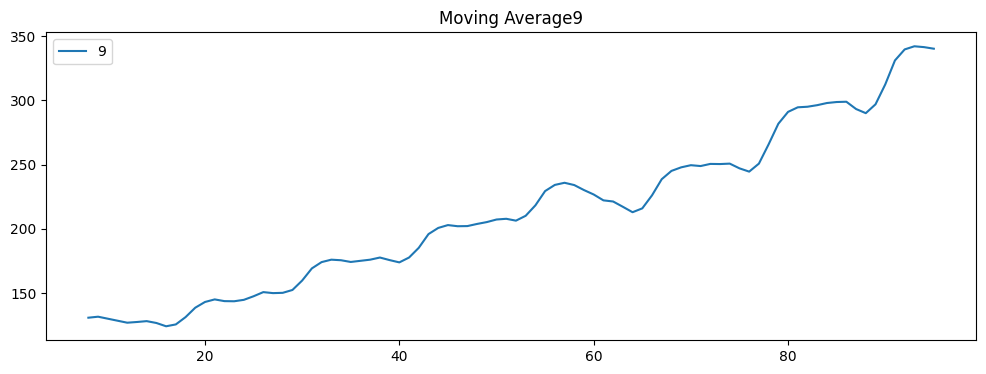

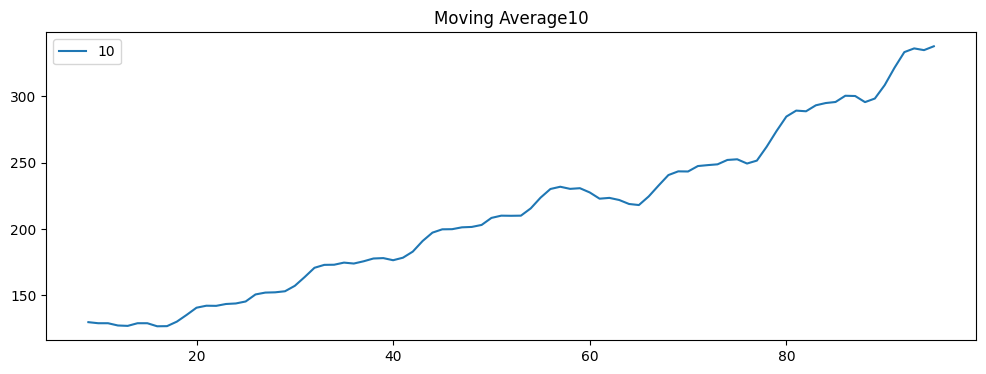

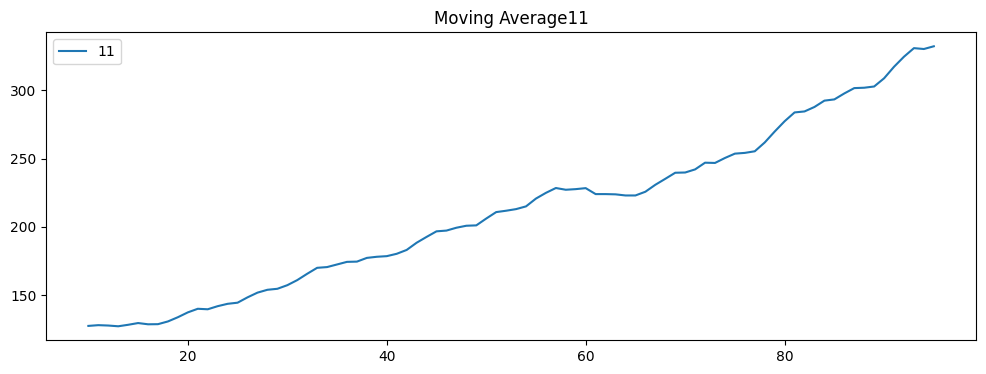

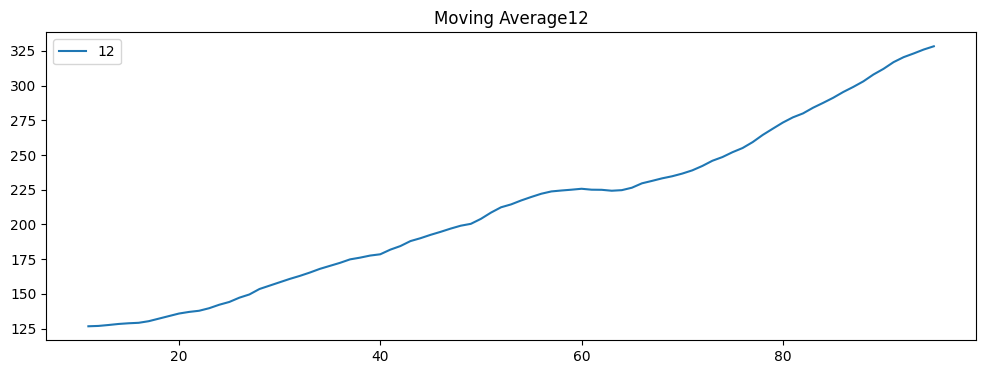

In [47]:
airline.Passengers.plot(label='org')
plt.title('Original Series')
for i in range(2,13):
  airline['Passengers'].rolling(i).mean().plot(label=str(i))
  plt.title('Moving Average'+str(i))
  plt.legend(loc='best')
  plt.show()

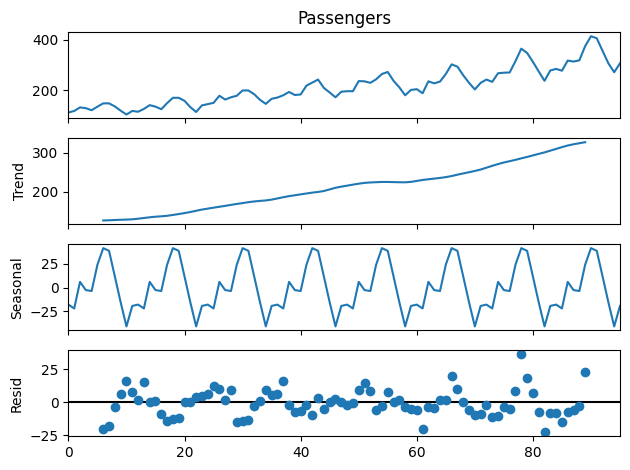

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_ts_add=seasonal_decompose(airline.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

**ACF plots and PACF plots**

The autocorrelation function (ACF) is a statistical technique that we can use to identify how correlated the values in a time series are with each other. The ACF plots the correlation coefficient against the lag, which is measured in terms of a number of periods or units.

The correlation coefficient can range from -1 (a perfect negative relationship) to +1 (a perfect positive relationship). A coefficient of 0 means that there is no relationship between the variables.

Partial autocorrelation is a statistical measure that captures the correlation between two variables after controlling for the effects of other variables.



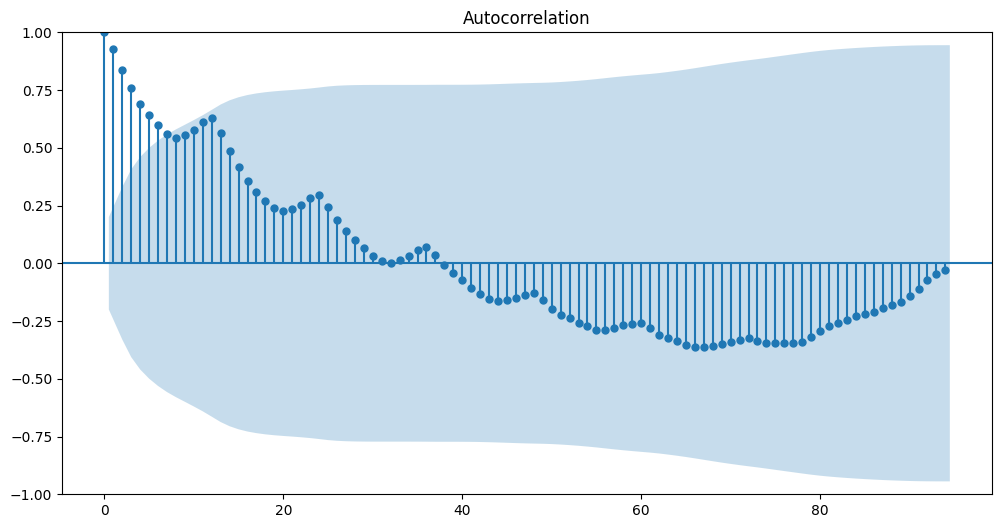

In [48]:
import statsmodels.graphics.tsaplots as tsa_plots
plt.rc('figure',figsize=(12,6))
tsa_plots.plot_acf(airline.Passengers,lags=94)
plt.show()

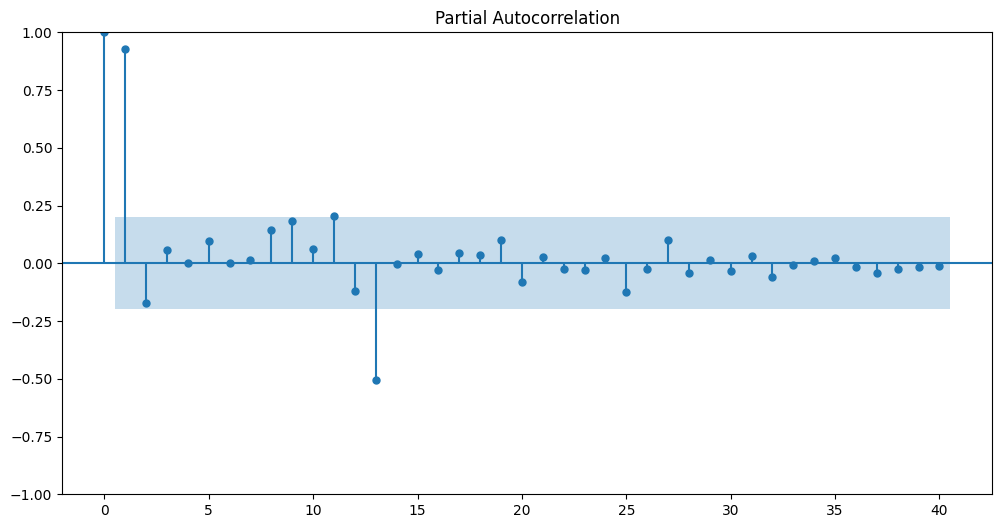

In [49]:
plt.rc('figure',figsize=(12,6))
tsa_plots.plot_pacf(airline.Passengers,lags=40)
plt.show()

In [50]:
train=air.head(72)
test=air.tail(24)

**<h3>Model</h3>**

In [23]:
# Linear Model
linear_model=smf.ols('Passengers~t',data=train).fit()
pred_linear=pd.Series(linear_model.predict(pd.DataFrame(test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_linear))**2))
rmse_linear

51.667792995646266

In [24]:
# Exponential Model
exp=smf.ols('log_passengers~t',data=train).fit()
pred_exp=pd.Series(exp.predict(pd.DataFrame(test['t'])))
rmse_exp=np.sqrt(np.mean((np.array(test['Passengers'])-np.array(np.exp(pred_exp)))**2))
rmse_exp

42.55232894600461

In [25]:
# Quadratic Model
Quad = smf.ols('Passengers~t+t_squared',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

51.99073640155397

In [26]:
# Additive Seasonality
add_sea = smf.ols('Passengers ~ month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',  data=train).fit()

pred_add_sea = pd.Series(add_sea.predict(test[[ 'month_Apr',
       'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan', 'month_Jul',
       'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct',
       'month_Sep']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

127.2645156532034

In [27]:
# Additive Seansonality Quadratic
add_sea_Quad = smf.ols('Passengers ~t +t_squared + month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data=train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['month_Apr',
       'month_Aug', 'month_Dec', 'month_Feb', 'month_Jan', 'month_Jul',
       'month_Jun', 'month_Mar', 'month_May', 'month_Nov', 'month_Oct',
       'month_Sep','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

35.241608485930655

In [28]:
# Multiplicative Seasonality
Mul_sea = smf.ols('log_passengers ~ month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

132.18762800263448

In [29]:
# Multiplicative Additive Seasonality
Mul_Add_sea = smf.ols('log_passengers ~ t+ month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data = train).fit()
pred_Mult_add_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

132.18762800263448

In [30]:
data = {"MODEL":pd.Series(["linear","Exp","Quad","add_sea","add_sea_quad","Mult_sea","Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
4,add_sea_quad,35.241608
1,Exp,42.552329
0,linear,51.667793
2,Quad,51.990736
3,add_sea,127.264516
5,Mult_sea,132.187628
6,Mult_add_sea,132.187628


In [31]:
# Data Driven Models
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import math
import sklearn.metrics

def rmse(actual, pred):
    mse = sklearn.metrics.mean_squared_error(actual, pred)
    rmse = math.sqrt(mse)
    return rmse

In [32]:
# Simple Exponential Method
ses_model = SimpleExpSmoothing(train["Passengers"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])
rmse_ses = rmse(test.Passengers, pred_ses)
rmse_ses

83.65334218812295

In [33]:
# Holt Method
hw_model = Holt(train["Passengers"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
rmse_hw = rmse(test.Passengers, pred_hw)
rmse_hw

148.18690002779988

In [34]:
# Holts Winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(train["Passengers"],seasonal="add",trend="add",seasonal_periods=4).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])
rmse_hwe_add_add = rmse(test.Passengers, pred_hwe_add_add)
rmse_hwe_add_add

77.6983138429044

In [35]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(train["Passengers"],seasonal="mul",trend="add",seasonal_periods=4).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = test.index[0],end = test.index[-1])
rmse_mul_add =rmse(test.Passengers, pred_hwe_mul_add)
rmse_mul_add

78.97904721328788

In [36]:
# Comparing the results
data = {"MODEL":pd.Series(["linear","Exp","Quad","add_sea","add_sea_quad","Mult_sea","Mult_add_sea",'ses_model', 'hw_model', 'hwe_model_add_add', 'hwe_model_mul_add']),
        "RMSE_Values":pd.Series([rmse_linear,rmse_exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea, rmse_ses, rmse_hw,rmse_hwe_add_add,rmse_mul_add  ])}
table_rmse=pd.DataFrame(data)
table_rmse = table_rmse.sort_values(by=['RMSE_Values'])
table_rmse

,MODEL,RMSE_Values
4,add_sea_quad,35.241608
1,Exp,42.552329
0,linear,51.667793
2,Quad,51.990736
9,hwe_model_add_add,77.698314
10,hwe_model_mul_add,78.979047
7,ses_model,83.653342
3,add_sea,127.264516
5,Mult_sea,132.187628
6,Mult_add_sea,132.187628


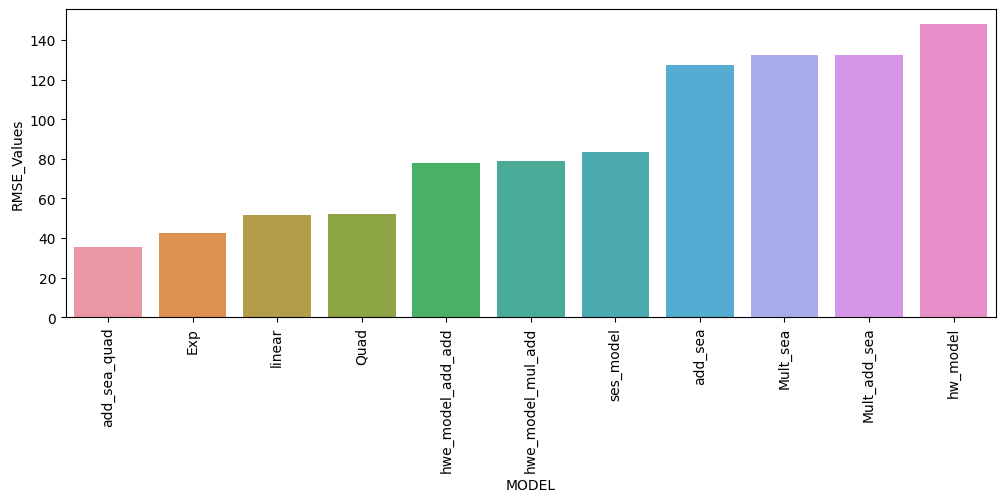

In [37]:
sns.barplot(x="MODEL" , y="RMSE_Values",data=table_rmse)
plt.xticks(rotation = 90)
plt.show()

In [38]:
add_sea_Quad = smf.ols('Passengers ~t +t_squared + month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data=air).fit()
pred= add_sea_Quad.predict(air.tail())
forecast = pd.DataFrame()

forecast['actual_passengers'] = air.Passengers.tail()
forecast['Predicted_passengers'] = np.round(pred, 0)

forecast

,actual_passengers,Predicted_passengers
91,405,371.0
92,355,344.0
93,306,317.0
94,271,293.0
95,306,319.0


In [39]:
new_df = pd.DataFrame()
new_df['t'] = np.arange(97,109,1)
new_df['t_squared'] = np.square(new_df.t)
new_df['month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
new_df = pd.get_dummies(new_df)
new_df.head()

,t,t_squared,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,97,9409,0,0,0,0,1,0,0,0,0,0,0,0
1,98,9604,0,0,0,1,0,0,0,0,0,0,0,0
2,99,9801,0,0,0,0,0,0,0,1,0,0,0,0
3,100,10000,1,0,0,0,0,0,0,0,0,0,0,0
4,101,10201,0,0,0,0,0,0,0,0,1,0,0,0


In [40]:
add_sea_Quad = smf.ols('Passengers ~t +t_squared + month_Apr + month_Aug+  month_Dec+ month_Feb+  month_Jan+  month_Jul+ month_Jun+  month_Mar+  month_May+  month_Nov+  month_Oct+ month_Sep',data=air).fit()
pred= add_sea_Quad.predict(new_df)

new_df['forcasted'] = pred

new_df

,t,t_squared,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,forcasted
0,97,9409,0,0,0,0,1,0,0,0,0,0,0,0,328.328687
1,98,9604,0,0,0,1,0,0,0,0,0,0,0,0,329.438178
2,99,9801,0,0,0,0,0,0,0,1,0,0,0,0,359.547668
3,100,10000,1,0,0,0,0,0,0,0,0,0,0,0,354.907159
4,101,10201,0,0,0,0,0,0,0,0,1,0,0,0,356.141650
5,102,10404,0,0,0,0,0,0,1,0,0,0,0,0,385.376141
6,103,10609,0,0,0,0,0,1,0,0,0,0,0,0,413.360631
7,104,10816,0,1,0,0,0,0,0,0,0,0,0,0,412.845122
8,105,11025,0,0,0,0,0,0,0,0,0,0,0,1,385.829613
9,106,11236,0,0,0,0,0,0,0,0,0,0,1,0,358.939103


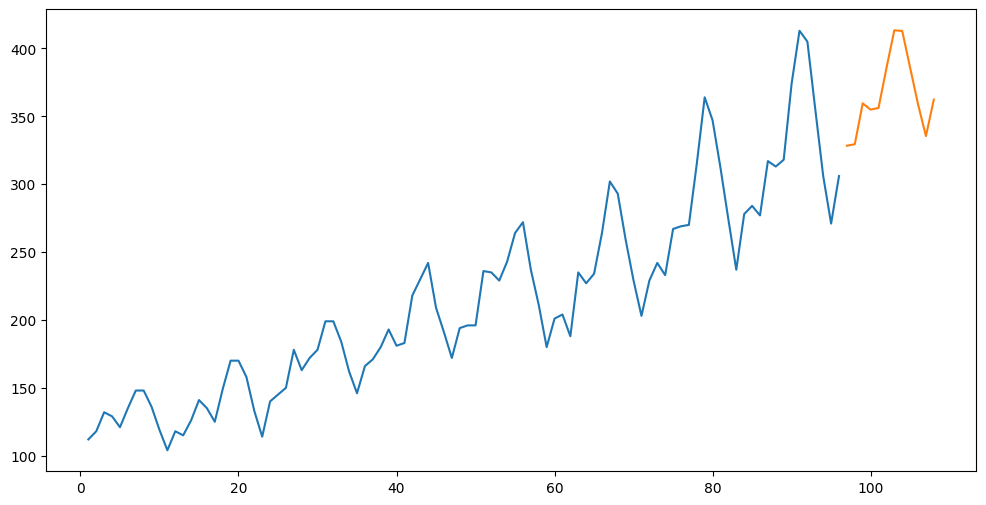

In [51]:
plt.figure(figsize=(12,6))
plt.plot(air.t , air.Passengers)
plt.plot(new_df.t , new_df.forcasted)